EXTRA (APÉNDICE)

En este notebook se entrenan diferentes modelos predictivos usando la puntuación OASIS para predecir si una estancia en UCI va a ser > 3 días o no. Luego se evalua el rendimiento de los modelos con ACC, AUC-ROC, AUC-PR, confusion matrix....También se realiza Cross Validation y student-t-test para determinar si las diferencias entre los resultados son estadísticamente significativas.

Obs. Ejecute primero '03calculateOASIS.ipynb' para obtener 'result_24_horas_final.csv'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pylab
import seaborn as sns
from tqdm import tqdm
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import stats


matplotlib.style.use('ggplot')

In [2]:
result_24_horas_final=pd.read_csv('result_24_horas_final.csv')

In [3]:
result_24_horas_final.isnull().sum()

Unnamed: 0            0
Unnamed: 0.1          0
SUBJECT_ID            0
HADM_ID               0
ADMITTIME             0
ADMISSION_TYPE        0
ICUSTAY_ID            0
INTIME                0
LOS                  10
AGE                   0
PRELOS                0
OASIS             13655
OASIS_NONAN           0
dtype: int64

In [4]:
result_24_horas_final = result_24_horas_final[result_24_horas_final['LOS'].notnull()] 
result_24_horas_final.isnull().sum()

Unnamed: 0            0
Unnamed: 0.1          0
SUBJECT_ID            0
HADM_ID               0
ADMITTIME             0
ADMISSION_TYPE        0
ICUSTAY_ID            0
INTIME                0
LOS                   0
AGE                   0
PRELOS                0
OASIS             13645
OASIS_NONAN           0
dtype: int64

In [5]:
#Excluir admissions < 18 years old, ya que tendran medidas fisiológicas distintas de las de los adultos 
result_24_horas_final = result_24_horas_final[~(result_24_horas_final['AGE'] < 18)]

In [6]:
print(result_24_horas_final.shape)
print('unique SUBJECT_ID:', result_24_horas_final.SUBJECT_ID.nunique())
print('unique HADM_ID   :', result_24_horas_final.HADM_ID.nunique())
print('unique ICUSTAY_ID   :', result_24_horas_final.ICUSTAY_ID.nunique())
result_24_horas_final.head()

(53329, 13)
unique SUBJECT_ID: 38510
unique HADM_ID   : 49692
unique ICUSTAY_ID   : 53329


,Unnamed: 0,Unnamed: 0.1,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,LOS,AGE,PRELOS,OASIS,OASIS_NONAN
0,0,0,59618,101145,2102-01-20 20:38:00,EMERGENCY,226547,2102-01-20 20:39:57,0.9954,74.430137,0.0,33.0,33.0
1,1,0,69108,158993,2132-01-15 23:26:00,ELECTIVE,297532,2132-01-16 06:22:40,1.4185,79.257534,6.9,29.0,29.0
2,2,0,14008,173497,2136-01-31 07:30:00,ELECTIVE,217593,2136-01-31 18:37:56,0.9808,76.789041,11.1,20.0,20.0
3,3,0,2187,128059,2134-04-21 02:22:00,EMERGENCY,212355,2134-04-21 02:24:10,5.6340,46.487671,0.0,NaN,0.0
4,4,0,41040,118624,2135-05-07 11:39:00,EMERGENCY,224627,2135-05-07 11:40:19,5.2510,80.178082,0.0,41.0,41.0


Duration for each single icustay_id is the LOS measured in days. LOS_C are computed by binarization.

In [7]:
result_24_horas_final['LOS']=np.where(result_24_horas_final['LOS']>3, 1, 0) # 0 "estancia corta", 1 "estancia larga"
print(result_24_horas_final.shape)
result_24_horas_final.head()

(53329, 13)


,Unnamed: 0,Unnamed: 0.1,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,LOS,AGE,PRELOS,OASIS,OASIS_NONAN
0,0,0,59618,101145,2102-01-20 20:38:00,EMERGENCY,226547,2102-01-20 20:39:57,0,74.430137,0.0,33.0,33.0
1,1,0,69108,158993,2132-01-15 23:26:00,ELECTIVE,297532,2132-01-16 06:22:40,0,79.257534,6.9,29.0,29.0
2,2,0,14008,173497,2136-01-31 07:30:00,ELECTIVE,217593,2136-01-31 18:37:56,0,76.789041,11.1,20.0,20.0
3,3,0,2187,128059,2134-04-21 02:22:00,EMERGENCY,212355,2134-04-21 02:24:10,1,46.487671,0.0,NaN,0.0
4,4,0,41040,118624,2135-05-07 11:39:00,EMERGENCY,224627,2135-05-07 11:40:19,1,80.178082,0.0,41.0,41.0


### Predecir en 24  horas  (considerando los oasis_variable nan como 0.0 (usar np.nansum), i.e. en rango 'normal') + mismo cohorte que benchmark

In [8]:
result_24_horas_nonnan=result_24_horas_final[['LOS','OASIS_NONAN','ICUSTAY_ID']]
result_24_horas_nonnan.head()

,LOS,OASIS_NONAN,ICUSTAY_ID
0,0,33.0,226547
1,0,29.0,297532
2,0,20.0,217593
3,1,0.0,212355
4,1,41.0,224627


In [9]:
result_24_horas_nonnan['LOS'].value_counts()

0    33797
1    19532
Name: LOS, dtype: int64

In [10]:
#from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Normalmente basta con train_test_split para tener conjunto de entrenamiento (Train set) y conjunto de prueba (Test set). Pero como queremos comparar con otros modelos, recomienda mantener un mismo Test set. Por lo tanto, usamos ficheros llamados 'listfilexx' para poder rastrear el Test/Train set. (obs. estas listfiles se obtienen ejecutando create_losxdays_icustayidListfiles.py)

In [11]:
cohorte_test_benchmark = pd.read_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/lengthOfStay/test/listfileLos3.csv')
cohorte_test_benchmark.rename(columns={'icustayid': 'ICUSTAY_ID'}, inplace=True)
print(cohorte_test_benchmark.shape)
cohorte_test_benchmark.head()

(5282, 3)


,stay,y_true,ICUSTAY_ID
0,10000_episode1_timeseries.csv,0,247610
1,10011_episode1_timeseries.csv,1,232110
2,10012_episode1_timeseries.csv,0,277998
3,10019_episode1_timeseries.csv,0,228977
4,10026_episode1_timeseries.csv,0,277021


In [12]:
test_set=pd.merge(cohorte_test_benchmark, result_24_horas_nonnan, how='left', on=['ICUSTAY_ID'])
print(test_set.shape)
test_set.head()

(5282, 5)


,stay,y_true,ICUSTAY_ID,LOS,OASIS_NONAN
0,10000_episode1_timeseries.csv,0,247610,0,26.0
1,10011_episode1_timeseries.csv,1,232110,1,27.0
2,10012_episode1_timeseries.csv,0,277998,0,27.0
3,10019_episode1_timeseries.csv,0,228977,0,48.0
4,10026_episode1_timeseries.csv,0,277021,0,34.0


In [13]:
test_set.isnull().sum()

stay           0
y_true         0
ICUSTAY_ID     0
LOS            0
OASIS_NONAN    0
dtype: int64

In [14]:
test_set[test_set['y_true'] == test_set['LOS']].shape

(5282, 5)

In [15]:
#We can see that they have same LOS, all correct
test_set[~(test_set['y_true'] == test_set['LOS'])]

,stay,y_true,ICUSTAY_ID,LOS,OASIS_NONAN


In [16]:
#Solo hace falta ejecutar esta linea una vez, que genera listfile para modelos con times_series
test_set['ICUSTAY_ID'].to_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/lengthOfStay/test/listfile.csv', index=False,header='ICUSTAY_ID')

In [17]:
X_test=pd.DataFrame(test_set['OASIS_NONAN'])
y_test=pd.DataFrame(test_set['LOS'])

In [18]:
cohorte_train_benchmark = pd.read_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/lengthOfStay/train/listfileLos3.csv')
cohorte_train_benchmark.rename(columns={'icustayid': 'ICUSTAY_ID'}, inplace=True)
print(cohorte_train_benchmark.shape)
cohorte_train_benchmark.head()

(29846, 3)


,stay,y_true,ICUSTAY_ID
0,91051_episode1_timeseries.csv,0,209804
1,19208_episode2_timeseries.csv,0,208696
2,41432_episode1_timeseries.csv,0,229628
3,65089_episode1_timeseries.csv,0,263325
4,17882_episode4_timeseries.csv,0,269666


In [19]:
train_set=pd.merge(cohorte_train_benchmark, result_24_horas_nonnan, how='left', on=['ICUSTAY_ID'])
print(train_set.shape)
train_set.head()

(29846, 5)


,stay,y_true,ICUSTAY_ID,LOS,OASIS_NONAN
0,91051_episode1_timeseries.csv,0,209804,0,20.0
1,19208_episode2_timeseries.csv,0,208696,0,30.0
2,41432_episode1_timeseries.csv,0,229628,0,30.0
3,65089_episode1_timeseries.csv,0,263325,0,44.0
4,17882_episode4_timeseries.csv,0,269666,0,24.0


In [20]:
train_set.isnull().sum()

stay           0
y_true         0
ICUSTAY_ID     0
LOS            0
OASIS_NONAN    0
dtype: int64

In [21]:
train_set[train_set['y_true'] == train_set['LOS']].shape

(29846, 5)

In [22]:
#Solo hace falta ejecutar esta linea una vez, que genera listfile para modelos con times_series
train_set['ICUSTAY_ID'].to_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/lengthOfStay/train/listfile.csv', index=False,header='ICUSTAY_ID')

In [23]:
X_train=pd.DataFrame(train_set['OASIS_NONAN'])
y_train=pd.DataFrame(train_set['LOS'])

In [24]:
X = (pd.concat([X_train, X_test])).to_numpy() #para Cross Validation, usar el dataset completo
y = (pd.concat([y_train, y_test])).to_numpy()

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
X_train


array([[-1.22720012],
       [-0.22210936],
       [-0.22210936],
       ...,
       [ 0.17992694],
       [ 0.58196324],
       [ 1.9890903 ]])

In [27]:
X_test

array([[-0.62414567],
       [-0.52363659],
       [-0.52363659],
       ...,
       [-1.22720012],
       [ 0.17992694],
       [-0.42312751]])

Random Forest same class weight

In [28]:
clf=RandomForestClassifier(n_estimators=10, random_state = 42)
clf.fit(X_train,np.ravel(y_train))
y_pred=clf.predict(X_test)
test_ac=np.round(metrics.accuracy_score(y_test, y_pred)*100,4)
train_ac=np.round(clf.score(X_train, y_train)*100,4)
print("Accuracy test:",test_ac)
print("Accuracy train:",train_ac)

Accuracy test: 65.0511
Accuracy train: 64.9032


In [29]:
y_pred_probas=clf.predict_proba(X_test)
y_pred_probas #probability of being [class 0, class 1]

array([[0.72525449, 0.27474551],
       [0.70960555, 0.29039445],
       [0.70960555, 0.29039445],
       ...,
       [0.79327636, 0.20672364],
       [0.59381375, 0.40618625],
       [0.68767047, 0.31232953]])

In [30]:
y_pred_probas[:, 1] #probability of being class 1(LOS>3)
#Nota: usamos probabilities para calculo de auc_roc. Porque en el benchmark usa probabilities y además
#el resultado de auc_roc varia si usa probilidad o valores enteros de 0/1.

array([0.27474551, 0.29039445, 0.29039445, ..., 0.20672364, 0.40618625,
       0.31232953])

In [31]:
auroc = metrics.roc_auc_score(y_test, y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)


AUC-ROC:  0.6590811326344301
AUC-PR:  0.5435824269359687


In [32]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)


[[2824  416]
 [1430  612]]


Mirando confusion matrix, ahora estan mas balanceado, el accuracy bajo.

In [33]:
cm = metrics.confusion_matrix(y_test, y_pred)
score = np.round(clf.score(X_test, y_test)*100,4)

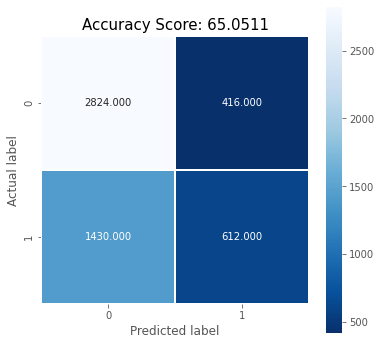

In [34]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

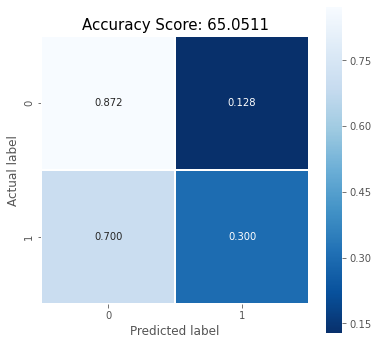

In [35]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

In [36]:
#Manteniendo random_state = 42 hara que mantenga mismos split_train_test.

In [37]:
#Manera 1: To plot curves: #TODO: revisar
#scaler = StandardScaler()
#RF_clf=RandomForestClassifier(n_estimators=10, random_state = 42)
#cv_RF = make_pipeline(scaler, RF_clf)
# Create k-Fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
#cv_RF_predicted = cross_val_predict(cv_RF, X,np.ravel(y),cv=kf, method='predict_proba')
#cv_RF_predicted1 = cross_val_predict(cv_RF, X,np.ravel(y), cv=kf)
#acc_RF=np.round(metrics.accuracy_score(np.ravel(y), cv_RF_predicted1)*100,4)

In [38]:
#manera 2
#https://amirhessam88.github.io/roc-vs-pr/

def customCrossValidationMetrics(classifier,X, y):
    scaler = StandardScaler()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    #ejemplo classifier=RandomForestClassifier(n_estimators=10, random_state = 42)
    aucprs = []
    aucrocs = []
    accuracies = []

    for train, test in cv.split(X, y): #train and test are indexes
        X_train_tranformed = scaler.fit_transform(X[train])
        X_test_tranformed = scaler.transform(X[test])
        probas_ = classifier.fit(X_train_tranformed, np.ravel(y[train])).predict_proba(X_test_tranformed)
        # Compute PR curve and area the curve
        precision, recall, thresholds = metrics.precision_recall_curve(y[test], probas_[:, 1])
        pr_auc =  np.round(metrics.auc(recall, precision), 6)
        aucprs.append(pr_auc)
        auroc =  np.round(metrics.roc_auc_score(y[test],probas_[:, 1]),6)
        aucrocs.append(auroc)

        y_pred_binary=classifier.predict(X_test_tranformed)
        acc = np.round(metrics.accuracy_score(y[test],y_pred_binary)*100,4)
        accuracies.append(acc)

    print ('aucpr scores:', aucprs)
    print("%0.4f mean aucpr with a standard deviation of %0.4f" % (np.mean(aucprs), np.std(aucprs)))

    print ('aucroc scores:', aucrocs)
    print("%0.4f mean aucroc with a standard deviation of %0.4f" % (np.mean(aucrocs), np.std(aucrocs)))

    print ('accuracy scores:', accuracies)
    print("%0.4f mean accuracy with a standard deviation of %0.4f" % (np.mean(accuracies), np.std(accuracies)))
    
    return aucprs, aucrocs, accuracies


In [39]:
classifier=RandomForestClassifier(n_estimators=10, random_state = 42)
aucprs_RF, aucrocs_RF, accuracies_RF = customCrossValidationMetrics(classifier, X, y)

aucpr scores: [0.521526, 0.535587, 0.536623, 0.544644, 0.52562]
0.5328 mean aucpr with a standard deviation of 0.0083
aucroc scores: [0.655988, 0.659277, 0.651154, 0.676124, 0.656375]
0.6598 mean aucroc with a standard deviation of 0.0086
accuracy scores: [64.4179, 64.6741, 64.3467, 65.1957, 65.5231]
64.8315 mean accuracy with a standard deviation of 0.4565


Random Forest different class weight

In [40]:
clf=RandomForestClassifier(n_estimators=10, random_state = 42,class_weight='balanced')
clf.fit(X_train,np.ravel(y_train))
y_pred=clf.predict(X_test)
test_ac=np.round(metrics.accuracy_score(y_test, y_pred)*100,4)
train_ac=np.round(clf.score(X_train, y_train)*100,4)
print("Accuracy test:",test_ac)
print("Accuracy train:",train_ac)

Accuracy test: 61.5676
Accuracy train: 61.9916


In [41]:
y_pred_probas=clf.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test,  y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test,  y_pred_probas[:, 1]) #same as benchmark
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)


AUC-ROC:  0.6590933755335486
AUC-PR:  0.5435136643102615


In [42]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)


[[1990 1250]
 [ 780 1262]]


In [43]:
cm = metrics.confusion_matrix(y_test, y_pred)
score = np.round(clf.score(X_test, y_test)*100,4)

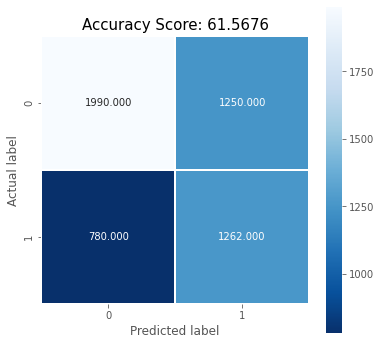

In [44]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

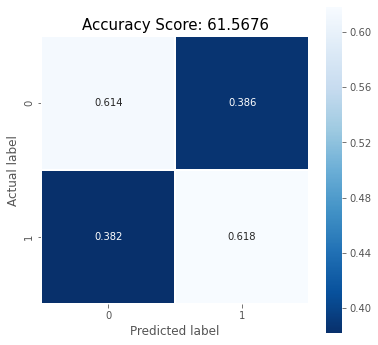

In [45]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

In [46]:
#Manera 2: To plot curves:
scaler = StandardScaler()
RF_clf_weighted=RandomForestClassifier(n_estimators=10, random_state = 42, class_weight='balanced')
cv_RF_weighted = make_pipeline(scaler, RF_clf_weighted)
# Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_RF_weighted_predicted = cross_val_predict(cv_RF_weighted, X,np.ravel(y),cv=kf, method='predict_proba')
cv_RF_weighted_predicted1 = cross_val_predict(cv_RF_weighted, X,np.ravel(y), cv=kf)
acc_RF_weighted=np.round(metrics.accuracy_score(np.ravel(y), cv_RF_weighted_predicted1)*100,4)

In [47]:
classifier=RandomForestClassifier(n_estimators=10, random_state = 42, class_weight='balanced')
aucprs_RF_weighted, aucrocs_RF_weighted, accuracies_RF_weighted = customCrossValidationMetrics(classifier, X, y)

aucpr scores: [0.521514, 0.535737, 0.5371, 0.544586, 0.525744]
0.5329 mean aucpr with a standard deviation of 0.0083
aucroc scores: [0.655946, 0.659265, 0.651133, 0.676104, 0.656384]
0.6598 mean aucroc with a standard deviation of 0.0086
accuracy scores: [61.187, 62.9661, 62.2118, 63.5018, 62.2918]
62.4317 mean accuracy with a standard deviation of 0.7808


Logistic Regression same class weight

In [48]:
logreg = LogisticRegression()
logreg.fit(X_train, np.ravel(y_train))
y_pred = logreg.predict(X_test)
actr=np.round(100*logreg.score(X_train, y_train),4)
acte=np.round(100*logreg.score(X_test, y_test),4)
print('Accuracy of logistic regression classifier on train set:', actr)
print('Accuracy of logistic regression classifier on test set:', acte)


Accuracy of logistic regression classifier on train set: 64.7691
Accuracy of logistic regression classifier on test set: 65.089


In [49]:
y_pred_probas=logreg.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test,  y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test,  y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)


AUC-ROC:  0.6565577350938926
AUC-PR:  0.5367460527554307


In [50]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[2881  359]
 [1485  557]]


In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.89      0.76      3240
           1       0.61      0.27      0.38      2042

    accuracy                           0.65      5282
   macro avg       0.63      0.58      0.57      5282
weighted avg       0.64      0.65      0.61      5282



In [52]:
#Manera 2: To plot curves:
scaler = StandardScaler()
LR_clf=LogisticRegression()
cv_LR = make_pipeline(scaler, LR_clf)
# Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_LR_predicted = cross_val_predict(cv_LR, X,np.ravel(y),cv=kf, method='predict_proba')
cv_LR_predicted1 = cross_val_predict(cv_LR, X,np.ravel(y), cv=kf)
acc_LR=np.round(metrics.accuracy_score(np.ravel(y), cv_LR_predicted1)*100,4)

In [53]:
classifier=LogisticRegression()
aucprs_LR, aucrocs_LR, accuracies_LR = customCrossValidationMetrics(classifier, X,y)

aucpr scores: [0.524477, 0.533812, 0.537692, 0.541745, 0.518267]
0.5312 mean aucpr with a standard deviation of 0.0086
aucroc scores: [0.654307, 0.657058, 0.649132, 0.669332, 0.655926]
0.6572 mean aucroc with a standard deviation of 0.0067
accuracy scores: [64.8449, 64.5602, 64.2186, 65.1103, 65.3808]
64.8230 mean accuracy with a standard deviation of 0.4071


Logistic Regression different class weight

In [54]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, np.ravel(y_train))
y_pred = logreg.predict(X_test)
actr=np.round(100*logreg.score(X_train, y_train),4)
acte=np.round(100*logreg.score(X_test, y_test),4)
print('Accuracy of logistic regression classifier on train set:', actr)
print('Accuracy of logistic regression classifier on test set:', acte)

Accuracy of logistic regression classifier on train set: 62.0653
Accuracy of logistic regression classifier on test set: 61.719


In [55]:
y_pred_probas=logreg.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test, y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)


AUC-ROC:  0.6565577350938926
AUC-PR:  0.5367460527554307


In [56]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[2020 1220]
 [ 802 1240]]


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67      3240
           1       0.50      0.61      0.55      2042

    accuracy                           0.62      5282
   macro avg       0.61      0.62      0.61      5282
weighted avg       0.63      0.62      0.62      5282



In [58]:
#Manera 2: To plot curves:
scaler = StandardScaler()
LR_clf_weighted=LogisticRegression(class_weight='balanced')
cv_LR_weighted = make_pipeline(scaler, LR_clf_weighted)
# Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_LR_weighted_predicted = cross_val_predict(cv_LR_weighted, X,np.ravel(y),cv=kf, method='predict_proba')
cv_LR_weighted_predicted1 = cross_val_predict(cv_LR_weighted, X,np.ravel(y), cv=kf)
acc_LR_weighted=np.round(metrics.accuracy_score(np.ravel(y), cv_LR_weighted_predicted1)*100,4)

In [59]:
classifier=LogisticRegression(class_weight='balanced')
aucprs_LR_weighted, aucrocs_LR_weighted, accuracies_LR_weighted = customCrossValidationMetrics(classifier, X,y)

aucpr scores: [0.524477, 0.533812, 0.537692, 0.541745, 0.518267]
0.5312 mean aucpr with a standard deviation of 0.0086
aucroc scores: [0.654307, 0.657058, 0.649132, 0.669332, 0.655926]
0.6572 mean aucroc with a standard deviation of 0.0067
accuracy scores: [61.3151, 62.1406, 61.5998, 63.4306, 61.5801]
62.0132 mean accuracy with a standard deviation of 0.7578


Plot ROC and PR curves

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


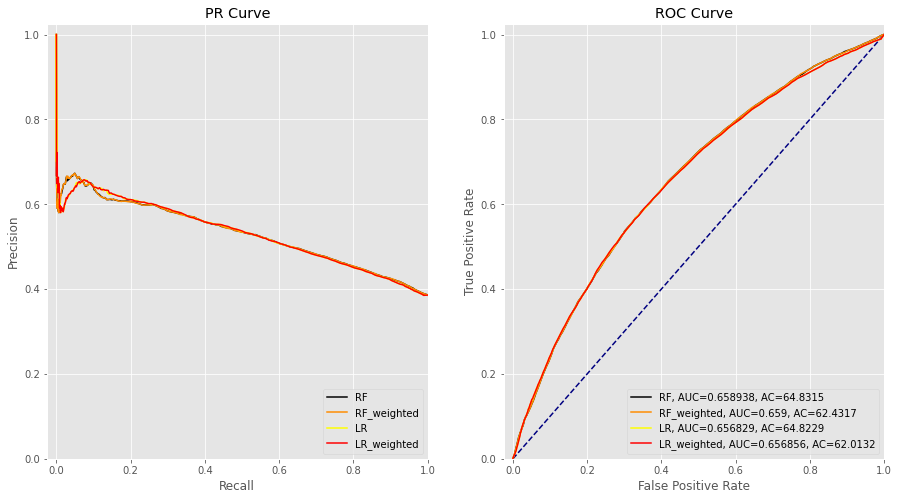

In [60]:
from sklearn.metrics import classification_report,confusion_matrix,auc,precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.025,1])
ax1.set_ylim([0,1.025])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax2.set_xlim([-0.025,1])
ax2.set_ylim([0,1.025])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

    
y_pred_proba=cv_RF_predicted[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
p,r,_ = precision_recall_curve(y,y_pred_proba)
auc = np.round(metrics.roc_auc_score(y, y_pred_proba),6)
ax2.plot(fpr,tpr,label="RF, AUC="+str(auc)+", AC="+str(acc_RF),color='black')
ax1.plot(r,p,label='RF',color='black')


y_pred_proba=cv_RF_weighted_predicted[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
p,r,_ = precision_recall_curve(y,y_pred_proba)
auc = np.round(metrics.roc_auc_score(y, y_pred_proba),6)
ax2.plot(fpr,tpr,label="RF_weighted, AUC="+str(auc)+", AC="+str(acc_RF_weighted),color='darkorange')
ax1.plot(r,p,label='RF_weighted',color='darkorange')
    
y_pred_proba=cv_LR_predicted[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
p,r,_ = precision_recall_curve(y,y_pred_proba)
auc = np.round(metrics.roc_auc_score(y, y_pred_proba),6)
ax2.plot(fpr,tpr,label="LR, AUC="+str(auc)+", AC="+str(acc_LR),color='yellow')
ax1.plot(r,p,label='LR',color='yellow')


y_pred_proba=cv_LR_weighted_predicted[::,1]
fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)
p,r,_ = precision_recall_curve(y,y_pred_proba)
auc = np.round(metrics.roc_auc_score(y, y_pred_proba),6)
ax2.plot(fpr,tpr,label="LR_weighted, AUC="+str(auc)+", AC="+str(acc_LR_weighted),color='red')
ax1.plot(r,p,label='LR_weighted',color='red')

ax1.legend(loc='lower right')    
ax2.legend(loc='lower right')
plt.savefig('OASIS_3daysLOS.eps', format='eps', dpi=1200)
plt.show()


Compare Statistical Significance Tests for Comparing Machine Learning Algorithms
(4 models)

https://stackoverflow.com/questions/54498235/compare-whether-the-difference-between-performance-accuracy-of-2-ml-models-is-st

In [61]:
print('RF vs RF_weighted: ', stats.ttest_rel(aucrocs_RF,aucrocs_RF_weighted))
print('RF_weighted vs LR: ', stats.ttest_rel(aucrocs_RF_weighted,aucrocs_LR))
print('LR vs LR_weighted: ', stats.ttest_rel(aucrocs_LR,aucrocs_LR_weighted))
print('LR_weighted vs RF: ', stats.ttest_rel(aucrocs_LR_weighted,aucrocs_RF))
print('LR_weighted vs RF_weighted: ', stats.ttest_rel(aucrocs_LR_weighted,aucrocs_RF_weighted))
print('LR vs RF: ', stats.ttest_rel(aucrocs_LR,aucrocs_RF))
#si p_value < 0.05, modelos tienen diferencias estadisticamente significativas   

RF vs RF_weighted:  Ttest_relResult(statistic=2.092897305035188, pvalue=0.10448806541146728)
RF_weighted vs LR:  Ttest_relResult(statistic=2.4164240687870358, pvalue=0.07304505841565287)
LR vs LR_weighted:  Ttest_relResult(statistic=nan, pvalue=nan)
LR_weighted vs RF:  Ttest_relResult(statistic=-2.4277179550852632, pvalue=0.07215859977929993)
LR_weighted vs RF_weighted:  Ttest_relResult(statistic=-2.4164240687870358, pvalue=0.07304505841565287)
LR vs RF:  Ttest_relResult(statistic=-2.4277179550852632, pvalue=0.07215859977929993)


In [62]:
print('RF vs RF_weighted: ', stats.ttest_rel(aucprs_RF,aucprs_RF_weighted))
print('RF_weighted vs LR: ', stats.ttest_rel(aucprs_RF_weighted,aucprs_LR))
print('LR vs LR_weighted: ', stats.ttest_rel(aucprs_LR,aucprs_LR_weighted))
print('LR_weighted vs RF: ', stats.ttest_rel(aucprs_LR_weighted,aucprs_RF))
print('LR_weighted vs RF_weighted: ', stats.ttest_rel(aucprs_LR_weighted,aucprs_RF_weighted))
print('LR vs RF: ', stats.ttest_rel(aucprs_LR,aucprs_RF))


RF vs RF_weighted:  Ttest_relResult(statistic=-1.4512340796226653, pvalue=0.22034117292231667)
RF_weighted vs LR:  Ttest_relResult(statistic=0.9891585821335477, pvalue=0.3785807252871808)
LR vs LR_weighted:  Ttest_relResult(statistic=nan, pvalue=nan)
LR_weighted vs RF:  Ttest_relResult(statistic=-0.904802174174101, pvalue=0.4167392572774711)
LR_weighted vs RF_weighted:  Ttest_relResult(statistic=-0.9891585821335477, pvalue=0.3785807252871808)
LR vs RF:  Ttest_relResult(statistic=-0.904802174174101, pvalue=0.4167392572774711)


Conclusión: Las diferencias de performance entre modelos no son estadísticamente significativas. 